# Bayesian Inference with Posterior Mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power as fmp

from Core_Functions import gmm_base as gb
from Core_Functions import gmm_plot as gp

[PUT THEORY UP UNTIL END OF LATEX DOCUMENT]

Now the intermediate distribution can be chosen to be the standard multivariate normal,

\begin{equation}
g(\mathbf{m}) = \phi(\mathbf{m}; \mathbf{0}, \mathbb{I}_d)
\end{equation}

THe approximation to this from the current set of mappings will then be

\begin{equation}
\tilde{g}(\mathbf{m}) = \sum_{j=1}^m q_j \frac{L(\beta_j(\mathbf{m}))g(\beta_j(\mathbf{m}))}{s_j} |\det J(\beta_j)|
\end{equation}

KEY IDEA: Fix the values of $L(\beta_j(\mathbf{m}))$ and change $\mathbf{m}$ to match as the map changes. This means we do not have to keep re-evaluating the likelihood but instead just change the models we are considering to match.

In [17]:
def Alpha_Maps(f):
    #so given a mixture, find each of the n alpha maps
    n = f.n
    d = f.d
    
    A = np.zeros([n,d,d])
    b = np.zeros([n,d])
    
    for i in range(n):
        A[i,:,:] = fmp(f.cov[i,:,:],-1/2)
        b[i,:] = - A[i,:,:] @ f.m[i,:]
        
    #at some stage, want to make new class that is set of affine maps and then return this instead of
    #having two arrays
    
    return A, b

def Inv_Alpha_Maps(f):
    n = f.n
    d = f.d
    
    A_inv = np.zeros([n,d,d])
    b_inv = np.zeros([n,d])
    
    for i in range(n):
        A_inv[i,:,:] = fmp(f.cov[i,:,:],1/2)
        b_inv[i,:] = f.m[i,:]
        
    #at some stage, want to make new class that is set of affine maps and then return this instead of
    #having two arrays
    
    return A, b

def Affine(A,b,x):
    num_x, d = np.shape(x)
    m_x = np.zeros([num_x, d])
    
    for k in range(num_x):
        m_x[k,:] = A @ x[k,:] + b.T
    return m_x

In [18]:
prior = gb.Gaussian_Mixture(2,1)

prior_w = np.array([0.3,0.7])
prior_m = np.array([-3,4]).reshape([2,1])
prior_c = np.array([1,1.4]).reshape([2,1,1])

prior.assign_w(prior_w)
prior.assign_m(prior_m)
prior.assign_cov(prior_c)

A, b = Alpha_Maps(prior)
A_inv, b_inv = Inv_Alpha_Maps(prior)

#key for this test is that prior=posterior so b_i = a_i^-1

m = np.linspace(-10,10,100).reshape([100,1])

Affine(A,b,m)

ValueError: could not broadcast input array from shape (2,2) into shape (1)

In [ ]:
#two key things we need functions for are Gaussian products and Gaussians under affine transformations

def Gaussian_Product(f,g):
    """
    Returns the product of Gaussian mixture models, rescaled to have unit mass. This simulates the case
    where the prior is a known mixture and the likelihood is a known mixture, returning the resulting
    posterior distriubtion.
    
    Inputs:
        f: one of the two mixtures to multiply (Gaussian_Mixture)
        g: the other mixture (Gaussian_Mixture)
    Outputs:
        fg: the product of mixtures f and g rescaled to unit mass (Gaussian_Mixture)
    """
    
    #need to check here that f and g are the same dimension
    
    n = f.n
    m = g.n
    
    nm = n * m
    
    fg_w = np.zeros(nm)
    fg_m = np.zeros([nm,f.d])
    fg_cov = np.zeros([nm,f.d,f.d])
    
    fg = gb.Gaussian_Mixture(nm,f.d)
    
    k = 0
    
    for i in range(n):
        for j in range(m):
            fm = f.m[i,:]
            gm = g.m[j,:]

            fcov = f.cov[i,:,:]
            gcov = g.cov[j,:,:]

            fg_cov[k,:,:] = np.linalg.inv(np.linalg.inv(fcov) + np.linalg.inv(gcov))
            fg_m[k,:] = fg_cov[k,:,:] @ (np.linalg.inv(fcov) @ fm + np.linalg.inv(gcov) @ gm)
            
            s = multivariate_normal.pdf(fm,mean=gm,cov=(fcov + gcov))
            
            fg_w[k] = f.w[i] * g.w[j] * s
            
            k += 1
            
    fg_w /= np.sum(fg_w)
    
    fg.assign_w(fg_w)
    fg.assign_m(fg_m)
    fg.assign_cov(fg_cov)
    
    return fg

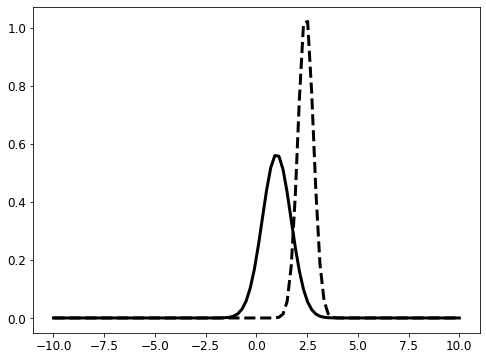

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b8909156d8>)

In [4]:
f = gb.Gaussian_Mixture(1,1)
g = gb.Gaussian_Mixture(1,1)

f.assign_w(np.array([1]))
g.assign_w(np.array([1]))

fm = np.zeros([1,1])
fcov = np.zeros([1,1,1])

gm = np.zeros([1,1])
gcov = np.zeros([1,1,1])

fm[0,0] = 1
gm[0,0] = 3

fcov[0,0,0] = 0.5
gcov[0,0,0] = 0.2

f.assign_m(fm)
f.assign_cov(fcov)

g.assign_m(gm)
g.assign_cov(gcov)

fg = Gaussian_Product(f,g)

gp.Source_Target_1D(f,fg,[-10,10])

The key thing we want to show here is that we get the target from applying optimal maps to source weighted by transport plan.

In [3]:
def Map_Finder(f,g):
    """
    Finds the alpha maps that transport the source components to the intermediate (standard multivariate normal)
    and the beta maps that transport this intermediate to the target components. These n + m maps fully define all
    n x m optimal transport maps between the Gaussian components via function compositions.
    Inputs:
        f: source distribution (Gaussian_Mixture)
        g: target distribution (Gaussian_Mixture)
    Outputs:
        a_A: the n matrices that define the alpha mapping (n x d x d array)
        a_b: the n vectors that define the alpha mapping (n x d array)
        b_A: the m matrices the define the beta mapping (m x d x d array)
        b_b: the m vectors that define the beta mapping (m x d array)
    """
    
    #some key information from the source and target GMM
    n = f.n
    m = g.n
    d = f.d
    
    #initialise the storage arrays from these mixture parameters
    a_A = np.zeros([n,d,d])
    a_b = np.zeros([n,d])
    b_A = np.zeros([m,d,d])
    b_b = np.zeros([m,d])
    
    #first, let's find the alpha maps
    for i in range(n):
        m_fi = f.m[i,:]
        S_fi = f.cov[i,:,:]
        
        A = fmp(S_fi,-1/2)
        b = - (A @ m_fi)
        
        a_A[i,:,:] = A
        a_b[i,:] = b
        
    #now we can do the beta maps
    for j in range(m):
        m_gj = g.m[j,:]
        S_gj = g.cov[j,:,:]
        
        A = fmp(S_gj,1/2)
        b = m_gj
        
        b_A[j,:,:] = A
        b_b[j,:] = b
    
    return a_A, a_b, b_A, b_b

def Alpha_Beta_Comp(a_A,a_b,b_A,b_b):
    """
    [DO WE NEED THIS FUNCTION AT ANY POINT? IF SAMPLING, YES, BUT NOT IF TRANSFORMING WHOLE DISTRIBUTION]
    """
    n = np.shape(a_A)[0]
    m = np.shape(b_A)[0]
    d = np.shape(a_b)[1]
    
    A_comp = np.zeros([n,m,d,d])
    b_comp = np.zeros([n,m,d])
    
    for i in range(n):
        for j in range(m):
            A_comp[i,j,:,:] = b_A[j,:,:] @ a_A[i,:,:]
            b_comp[i,j,:] = b_A[j,:,:] @ a_b[i,:] + b_b[j,:]
    return A_comp, b_comp

def Gaussian_Affine(f,A_store,b_store,P):
    """
    Applies a set of affine tranformations to the components of the inputs mixture. The order of the
    transformations must be the same order as the components.
    Inputs:
        f: source distribution (Gaussian_Mixture)
        A_store: matrix from each affine transformation to be applied (n x m x d x d array)
        b_store: vector from each affine transformation to be applied (n x m x d array)
        P: transport plan to be followed through mapping (n x m array)
    Returns:
        T_f: the source distribution under the transformations imposed (Gaussian_Mixture)
    """
    
    d = f.d
    n = f.n
    
    T_f = gb.Gaussian_Mixture(n,d)
    
    T_m = np.zeros([n,d])
    T_cov = np.zeros([n,d,d])
    
    for i in range(n):
        T_m[i,:] = A @ f.m[i,:] + b
        T_cov[i,:,:] = A @ f.cov[i,:,:] @ A.T
        
    T_f.assign_w(f.w)
    T_f.assign_m(T_m)
    T_f.assign_cov(T_cov)
    
    return T_f